# Creating the model

In [10]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

in_channels = 3  # Color images have 3 channels (RGB)
image_width = 256
image_height = 256
# Connect to the GPU if one exists.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("mps")

# VAE Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 4, 2, 1)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1)
        self.fc1 = nn.Linear(64 * (image_width // 4) * (image_height // 4), 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# VAE Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 64 * (image_width // 4) * (image_height // 4))
        self.deconv1 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.deconv2 = nn.ConvTranspose2d(32, in_channels, 4, 2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(x.size(0), 64, (image_width // 4), (image_height // 4))
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))
        return x

# VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mu, logvar


In [6]:
models_df = pd.read_csv("carbon_footprint/models_consumption.csv")
model_to_label = {model: idx for idx, model in enumerate(models_df['full name'])}
print(model_to_label)
len(model_to_label)

{'Ford Fiesta Sedan 2012': 0, 'FIAT 500 Convertible 2012': 1, 'Chevrolet Corvette ZR1 2012': 2, 'Lamborghini Gallardo LP 570-4 Superleggera 2012': 3, 'Honda Accord Coupe 2012': 4, 'Volvo C30 Hatchback 2012': 5, 'BMW 1 Series Convertible 2012': 6, 'Lamborghini Aventador Coupe 2012': 7, 'Suzuki SX4 Sedan 2012': 8, 'Hyundai Genesis Sedan 2012': 9, 'Chevrolet Silverado 1500 Extended Cab 2012': 10, 'Ford F-150 Regular Cab 2007': 11, 'Hyundai Azera Sedan 2012': 12, 'Chrysler Crossfire Convertible 2008': 13, 'Lamborghini Reventon Coupe 2008': 14, 'Hyundai Veracruz SUV 2012': 15, 'Suzuki Aerio Sedan 2007': 16, 'Ford F-450 Super Duty Crew Cab 2012': 17, 'Chrysler PT Cruiser Convertible 2008': 18, 'Ford Ranger SuperCab 2011': 19, 'Volkswagen Beetle Hatchback 2012': 20, 'Infiniti G Coupe IPL 2012': 21, 'Hyundai Sonata Hybrid Sedan 2012': 22, 'Jeep Wrangler SUV 2012': 23, 'Chevrolet TrailBlazer SS 2009': 24, 'Dodge Durango SUV 2007': 25, 'Volvo XC90 SUV 2007': 26, 'Ford Mustang Convertible 2007': 

100

In [ ]:
class CarDataset(Dataset):
    def __init__(self, root_dir="datasets_train/", annotations_file="datasets_train/train_annotation/_annotation.csv"):
        """
        Initialize the custom dataset.

        Args:
            root_dir (str): Path to the data folder.
            annotations_file (str): Path to the CSV file with image annotations.
            label_dict (dict): Mapping of class labels to integers.
            transforms (Bool, optional): To apply if training.
        """
        self.root_dir = os.path.join(os.getcwd(), root_dir)  
 
        self.data = pd.read_csv(annotations_file).dropna()
        self.transforms = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize((256,256)),
                torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]) # To be adjusted

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, "train",self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        model_str = self.data.iloc[idx, 6]
        model_label = model_to_label[model_str]

        return self.transforms(image), model_label

In [2]:
torch.cuda.empty_cache()

In [4]:
log_interval = 10
num_epochs = 50
# Define your training loop
def train_vae(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        x = data[0]  # Load your training data here
        x = x.to(device)  # Send data to GPU if available
        reconstructed_x, mu, logvar = model(x)
        loss = vae_loss(reconstructed_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(x):4d}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

# Define the VAE loss function
def vae_loss(reconstructed_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [7]:
# Train the VAE model
latent_dim = 2  # Choose the desired latent dimension
learning_rate = 1.e-4
dataset = CarDataset()
train_loader = torch.utils.data.DataLoader(dataset,
        batch_size=32,
        shuffle=True, drop_last=True)
vae = VAE(latent_dim).to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
for epoch in range(1, num_epochs + 1):
    train_vae(vae, train_loader, optimizer, epoch)  # Replace train_loader with your data loader

/Users/timotheschmidt/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error:

Train Epoch: 1 [   0/2089 (0%)]	Loss: 4531381.500000
Train Epoch: 1 [ 320/2089 (15%)]	Loss: 3672543.500000
Train Epoch: 1 [ 640/2089 (31%)]	Loss: -752488.937500
Train Epoch: 1 [ 960/2089 (46%)]	Loss: -11275927.000000
Train Epoch: 1 [1280/2089 (62%)]	Loss: -45551240.000000
Train Epoch: 1 [1600/2089 (77%)]	Loss: -40127152.000000
Train Epoch: 1 [1920/2089 (92%)]	Loss: -92249480.000000
Train Epoch: 2 [   0/2089 (0%)]	Loss: -59487184.000000
Train Epoch: 2 [ 320/2089 (15%)]	Loss: -82554408.000000
Train Epoch: 2 [ 640/2089 (31%)]	Loss: -98372592.000000
Train Epoch: 2 [ 960/2089 (46%)]	Loss: -126529056.000000
Train Epoch: 2 [1280/2089 (62%)]	Loss: -100010296.000000
Train Epoch: 2 [1600/2089 (77%)]	Loss: -69383320.000000
Train Epoch: 2 [1920/2089 (92%)]	Loss: -119448936.000000
Train Epoch: 3 [   0/2089 (0%)]	Loss: -104934832.000000
Train Epoch: 3 [ 320/2089 (15%)]	Loss: -150357328.000000
Train Epoch: 3 [ 640/2089 (31%)]	Loss: -156389088.000000
Train Epoch: 3 [ 960/2089 (46%)]	Loss: -175062464.0

KeyboardInterrupt: 

In [19]:
def plot_latent_vae(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))[0]
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', s=1)
        if i > num_batches:
            plt.colorbar()
            break

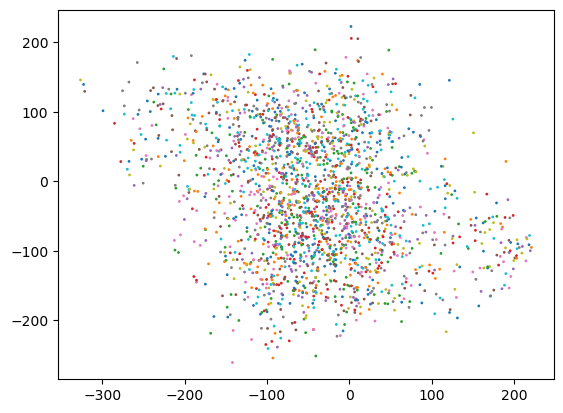

In [20]:
plot_latent_vae(vae, train_loader)

Pas très convaiquant

# Simpler architecture

In [1]:
import torch; torch.manual_seed(0)
import os
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch.utils
import torch.distributions
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm
import torchsummary
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
torch.cuda.empty_cache()
# Connect to the GPU if one exists.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("mps")

In [8]:
models_df = pd.read_csv("carbon_footprint/models_consumption.csv")
model_to_label = {model: idx for idx, model in enumerate(models_df['full name'])}
print(model_to_label)
len(model_to_label)

{'Ford Fiesta Sedan 2012': 0, 'FIAT 500 Convertible 2012': 1, 'Chevrolet Corvette ZR1 2012': 2, 'Lamborghini Gallardo LP 570-4 Superleggera 2012': 3, 'Honda Accord Coupe 2012': 4, 'Volvo C30 Hatchback 2012': 5, 'BMW 1 Series Convertible 2012': 6, 'Lamborghini Aventador Coupe 2012': 7, 'Suzuki SX4 Sedan 2012': 8, 'Hyundai Genesis Sedan 2012': 9, 'Chevrolet Silverado 1500 Extended Cab 2012': 10, 'Ford F-150 Regular Cab 2007': 11, 'Hyundai Azera Sedan 2012': 12, 'Chrysler Crossfire Convertible 2008': 13, 'Lamborghini Reventon Coupe 2008': 14, 'Hyundai Veracruz SUV 2012': 15, 'Suzuki Aerio Sedan 2007': 16, 'Ford F-450 Super Duty Crew Cab 2012': 17, 'Chrysler PT Cruiser Convertible 2008': 18, 'Ford Ranger SuperCab 2011': 19, 'Volkswagen Beetle Hatchback 2012': 20, 'Infiniti G Coupe IPL 2012': 21, 'Hyundai Sonata Hybrid Sedan 2012': 22, 'Jeep Wrangler SUV 2012': 23, 'Chevrolet TrailBlazer SS 2009': 24, 'Dodge Durango SUV 2007': 25, 'Volvo XC90 SUV 2007': 26, 'Ford Mustang Convertible 2007': 

100

In [2]:
class CarDataset(Dataset):
    def __init__(self, root_dir="datasets_train/", annotations_file="datasets_train/train_annotation/_annotation.csv"):
        """
        Initialize the custom dataset.

        Args:
            root_dir (str): Path to the data folder.
            annotations_file (str): Path to the CSV file with image annotations.
            label_dict (dict): Mapping of class labels to integers.
            transforms (Bool, optional): To apply if training.
        """
        self.root_dir = os.path.join(os.getcwd(), root_dir)  
 
        self.data = pd.read_csv(annotations_file).dropna()
        self.transforms = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize((256,256)),
                torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]) # To be adjusted

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, "train",self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        model_str = self.data.iloc[idx, 6]
        model_label = model_to_label[model_str]

        return self.transforms(image), model_label

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(3*256*256, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 3*256*256)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 3, 256, 256))
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [5]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        losses = []
        for x,_ in tqdm(data):
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            losses.append(loss.item())
            opt.step()
        print(f"Loss : {np.mean(losses):3f}")
            
    return autoencoder

In [6]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU
dataset = CarDataset()
data = DataLoader(dataset,
        batch_size=32,
        shuffle=True, drop_last=True)
#torchsummary.summary(autoencoder, (3, 256, 256))


In [9]:
train(autoencoder, data)

  0%|          | 0/20 [00:00<?, ?it/s]/Users/timotheschmidt/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/20 [09:04<?, ?it/s]


KeyboardInterrupt: 

In [10]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', s=0.1)
        if i > num_batches:
            plt.colorbar()
            break

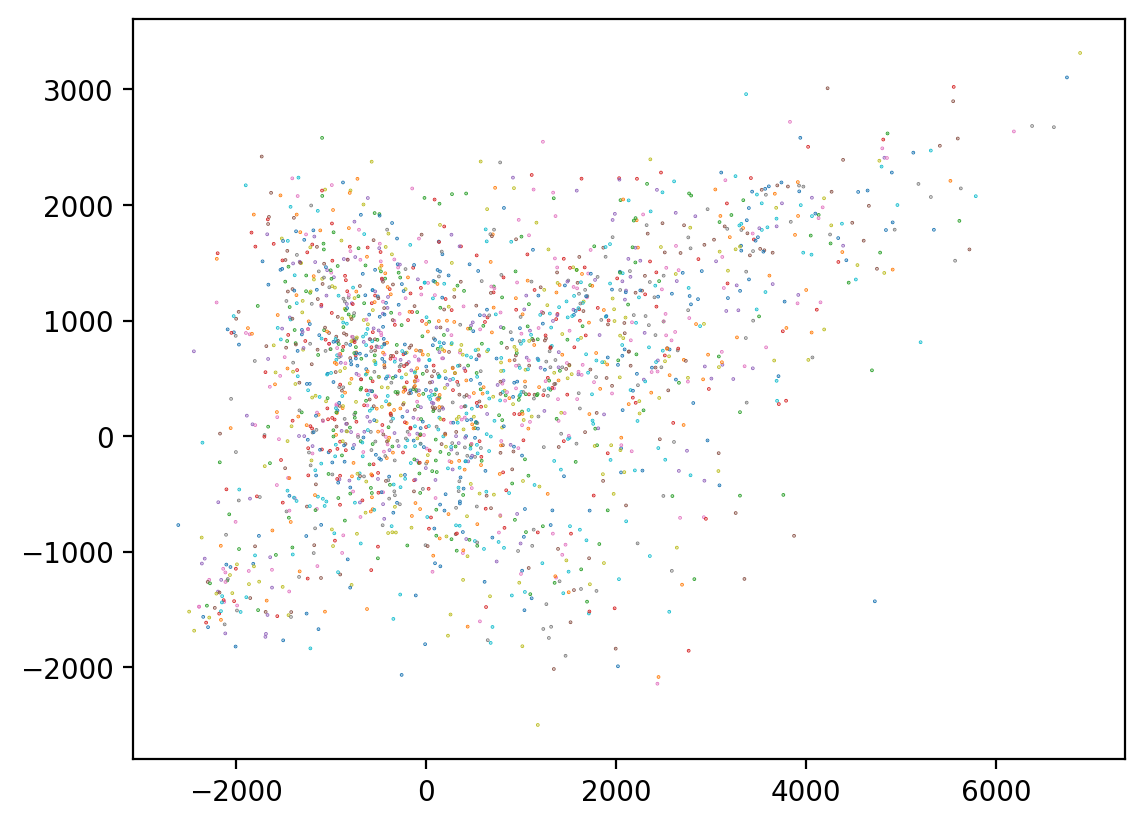

In [11]:
plot_latent(autoencoder, data)